# LAPD crimes database: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
#https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/63jg-8b9z
src = pd.read_csv('/Users/mhustiles/data/data/LA/Crime_Data_from_2010_to_Present.csv')

In [3]:
crimes = src

In [4]:
crimes.columns = crimes.columns.str.strip().str.lower()\
.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### These data are super messy...

In [5]:
crimes.rename(columns = { 
'dr_no':'record_id',
'date_rptd':'date_reported',
'date_occ':'date_occurred',
'time_occ':'time_occurred',
'area':'division',
'area_name':'division_name',
'rpt_dist_no':'reporting_district',
'part_1-2':'part_type',
'crm_cd':'crime_code',
'crm_cd_desc':'crime_code_description',
'mocodes':'modus_operandi_code',
'vict_age':'victim_age',
'vict_sex':'victim_sex',
'vict_descent':'victim_descent',
'premis_cd':'premises_code',
'premis_desc':'premises_description',
'weapon_used_cd':'weapon_code',
'weapon_desc':'weapon_description',
'status':'status_code',
'status_desc':'status_code_description',
'crm_cd_1':'crm_cd_1',
'crm_cd_2':'crm_cd_2',
'crm_cd_3':'crm_cd_3',
'crm_cd_4':'crm_cd_4',
'location':'address',
'cross_street':'cross_street',
'lat':'latitude',
'lon':'longitide',
 }, inplace = True)

### ... contunued

In [6]:
crimes['date_reported'] = crimes['date_reported'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = crimes['date_occurred'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = pd.to_datetime(crimes['date_occurred'], format='%m/%d/%Y')
crimes['year'] = crimes['date_occurred'].dt.year
crimes['quarter'] = crimes['date_occurred'].dt.quarter
crimes['day'] = crimes['date_occurred'].dt.day
crimes['month'] = crimes['date_occurred'].dt.month
crimes['weekday'] = crimes['date_occurred'].dt.weekday_name

In [7]:
crimes[[ 'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month', ]] = crimes[[
    'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month',]].astype(str)

In [8]:
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['premises_code'] = crimes['premises_code'].str.replace('.0','', regex=False)
crimes['crm_cd_1'] = crimes['crm_cd_1'].str.replace('.0','', regex=False)
crimes['crm_cd_2'] = crimes['crm_cd_2'].str.replace('.0','', regex=False)

In [9]:
crimes.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday
0,1307355,02/20/2010,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,48,M,H,501,SINGLE FAMILY DWELLING,nan,NaN,AA,Adult Arrest,900,nan,nan,nan,300 E GAGE AV,NaN,33.9825,-118.2695,2010,1,20,2,Saturday
1,11401303,09/13/2010,2010-09-12,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,0,M,W,101,STREET,nan,NaN,IC,Invest Cont,740,nan,nan,nan,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010,3,12,9,Sunday
2,70309629,08/09/2010,2010-08-09,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,0,M,H,103,ALLEY,nan,NaN,IC,Invest Cont,946,nan,nan,nan,1300 E 21ST ST,NaN,34.0224,-118.2524,2010,3,9,8,Monday
3,90631215,01/05/2010,2010-01-05,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,47,F,W,101,STREET,102.0,HAND GUN,IC,Invest Cont,900,998,nan,nan,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010,1,5,1,Tuesday
4,100100501,01/03/2010,2010-01-02,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,47,F,H,103,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday


In [10]:
crimes['time_occurred'] = crimes['time_occurred'].str.replace('.0','', regex=False)
crimes['time_occurred'] = crimes['time_occurred'].str.zfill(4)
crimes['hour'] = crimes['time_occurred'].str[:2]
crimes['minute'] = crimes['time_occurred'].str[2:]
crimes = crimes[crimes['hour'] != '0n']
crimes = crimes[crimes['hour'] != '24']

In [11]:
homicides = crimes[crimes['crime_code_description'].str.contains('CRIMINAL HOMICIDE', na=False)]

---

## Cases involving suspects or victimes defined by LAPD as 'homeless'

In [12]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])

In [13]:
mocodes = pd.read_csv('mo_codes.csv')

In [14]:
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


In [15]:
homeless_dates = ['2015','2016', '2017', '2018', '2019']

In [16]:
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('CRIMINAL HOMICIDE', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [17]:
len(homeless_victims)

16168

In [18]:
len(homeless_suspects)

33843

In [19]:
homeless_homicides_years = homeless_homicides.groupby(['year']).agg('size').reset_index(name='total')

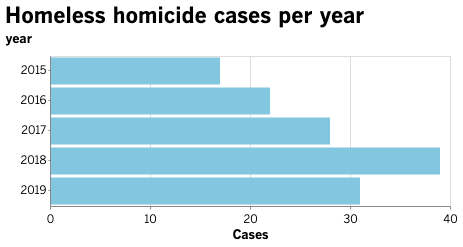

In [20]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("total:Q", title="Cases", axis=alt.Axis(format='', tickCount=5)),
).properties(height=150, width=400, columns=3, title='Homeless homicide cases per year')

In [21]:
homeless_cases_victim = homeless_victims.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [22]:
homeless_cases_victim.head(10)

,crime_code_description,total
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",3993
4,BATTERY - SIMPLE ASSAULT,2916
55,ROBBERY,1810
69,THEFT PLAIN - PETTY ($950 & UNDER),1664
37,INTIMATE PARTNER - SIMPLE ASSAULT,1632
36,INTIMATE PARTNER - AGGRAVATED ASSAULT,666
53,"RAPE, FORCIBLE",450
9,BRANDISH WEAPON,415
24,CRIMINAL THREATS - NO WEAPON DISPLAYED,324
3,ATTEMPTED ROBBERY,249


In [23]:
homeless_cases_suspect = homeless_suspects.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [36]:
homeless_cases_suspect.head(100)

,crime_code_description,total
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",4745
4,BATTERY - SIMPLE ASSAULT,4592
97,TRESPASSING,2823
76,ROBBERY,2713
80,SHOPLIFTING - PETTY THEFT ($950 & UNDER),2520
55,INTIMATE PARTNER - SIMPLE ASSAULT,1978
99,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",1476
90,THEFT PLAIN - PETTY ($950 & UNDER),1226
32,CRIMINAL THREATS - NO WEAPON DISPLAYED,1138
14,BURGLARY,1127


--- 

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [25]:
violations = crimes.groupby(['crime_code_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [26]:
violations.head(10)

,crime_code_description,total
5,BATTERY - SIMPLE ASSAULT,186258
22,BURGLARY FROM VEHICLE,158076
136,VEHICLE - STOLEN,155886
118,THEFT PLAIN - PETTY ($950 & UNDER),145922
21,BURGLARY,144417
116,THEFT OF IDENTITY,123666
75,INTIMATE PARTNER - SIMPLE ASSAULT,111737
132,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",106437
3,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",90253
133,VANDALISM - MISDEAMEANOR ($399 OR UNDER),88706


### Places where crimes occur?

In [27]:
places = crimes.groupby(['premises_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [28]:
places.head(10)

,premises_description,total
278,STREET,460268
267,SINGLE FAMILY DWELLING,417089
211,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",259047
233,PARKING LOT,146035
266,SIDEWALK,103165
224,OTHER BUSINESS,93916
311,"VEHICLE, PASSENGER/TRUCK",77786
64,DRIVEWAY,41592
80,GARAGE/CARPORT,36703
258,RESTAURANT/FAST FOOD,28372


### Areas of the city? 

In [29]:
divisions = crimes.groupby(['division_name'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [30]:
divisions.head(21)

,division_name,total
0,77th Street,141789
15,Southwest,132019
8,N Hollywood,110990
12,Pacific,109399
14,Southeast,108601
7,Mission,101132
10,Northeast,97774
9,Newton,97291
17,Van Nuys,97091
6,Hollywood,96124


### What kinds of weapons?

In [31]:
weapons = crimes.groupby(['weapon_description'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [32]:
weapons.head(10)

,weapon_description,total
65,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",419123
78,VERBAL THREAT,57214
75,UNKNOWN WEAPON/OTHER WEAPON,55699
27,HAND GUN,33231
58,SEMI-AUTOMATIC PISTOL,12644
32,KNIFE WITH BLADE 6INCHES OR LESS,12488
44,OTHER KNIFE,9505
73,UNKNOWN FIREARM,7713
77,VEHICLE,7065
50,REVOLVER,5490


### Which days of the week?

In [33]:
weekdays = crimes.groupby(['weekday'])\
.agg('size').reset_index(name='total').sort_values(by='total', ascending=False)

In [34]:
weekdays.head(7)

,weekday,total
0,Friday,316569
2,Saturday,296240
1,Monday,293367
6,Wednesday,291420
4,Thursday,289866
5,Tuesday,287415
3,Sunday,283341


### UCR type?

In [35]:
crimes['part_type'].value_counts('normalize').round(2)*100

1    55.0
2    45.0
Name: part_type, dtype: float64

---